# Deep Q Network Banana Hunter
### Training a Deep Q Network to Collect Yellow Bananas

**Author: [jstol](https://github.com/jstol)**

This project was completed as part of the Udacity [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

Code within this project is written from scratch (with some inspiration and tips taken from previous [DQN homework](https://github.com/udacity/deep-reinforcement-learning/tree/dc65050c8f47b365560a30a112fb84f762005c6b/dqn) in the Udacity program).

## Environment
The goal is to train an agent through (Deep) Q-Learning that is capable of navigating a world containing yellow and blue bananas. Yellow bananas result in a reward of +1, and blue bananas -1. The task is episodic, with the episode ending after a fixed amount of time. An agent that "solves" the environment is defined as achieving a reward of +13 or greater on average over 100 episodes.

The environment is provided by Udacity, and based on Unity's [ML-Agents](https://github.com/Unity-Technologies/ml-agents) framework.

Observations are delivered in the form of 37-dimensional floating point vectors, and include measurements such as the velocity of the agent. The actions available to the agent are `0` (walk forwards), `1` (walk backwards), `2` (turn left), and `3` (turn right).

## Model
The agent in this project learns through [Q-learning](https://en.wikipedia.org/wiki/Q-learning), specifically through a Deep Q Network (DQN) \[1\]. A simple feed-forward network (with 3 hidden layers) is used. The network architecture is configurable, but by default the agent makes use of the architecture as seen below:

![network architecture](images/network_architecture.png "The Project Network Architecture")

As seen in the code below, the agent is able to solve the environment in 1,170 episodes.

### Hyperparameters
Adam was used as the optimizer, and ReLU activation functions were used within the hidden layers. The agent can be configured with hyperparameters as desired, but the following settings are used by default:
- `update_freq` = 4: Frequency to update the DQNs.
- `buffer_size` = 20,000: Size of the replay buffer to maintain.
- `batch_size` = 64: Size of the batch to use for SGD.
- `gamma` = 0.99: Reward discount factor.
- `lr` = 0.001: Learning rate to use (Adam).
- `tau` = 0.001: The mixing factor to use when updating the target DQN. If None, use hard updates.
- `eps_start` = 1.0: Starting epsilon value.
- `eps_min` = 0.05: Minimum allowable epsilon value.
- `eps_decay` = 0.998: Epsilon decay factor.
- `max_num_episodes` = 2,000: Maximum number of episodes to let the agent run for.

### Future Work
The version of DQN used in this project stays fairly true to the original paper; however, it could be improved to aid in the agent's learning. For example, through the use of [Double Q-Learning](https://www.semanticscholar.org/paper/Deep-Reinforcement-Learning-with-Double-Q-Learning-Hasselt-Guez/3b9732bb07dc99bde5e1f9f75251c6ea5039373e), [Dueling Q Networks](https://www.semanticscholar.org/paper/Dueling-Network-Architectures-for-Deep-Learning-Wang-Schaul/4c05d7caa357148f0bbd61720bdd35f0bc05eb81), or [Prioritized Experience Replay](https://www.semanticscholar.org/paper/Prioritized-Experience-Replay-Schaul-Quan/c6170fa90d3b2efede5a2e1660cb23e1c824f2ca).

### References
  1. Mnih, Volodymyr, Koray Kavukcuoglu, David Silver, Andrei A. Rusu, Joel Veness, Marc G. Bellemare, Alex Graves, 
Martin A. Riedmiller, Andreas K. Fidjeland, Georg Ostrovski, Stig Petersen, Charles Beattie, Amir Sadik, Ioannis 
Antonoglou, Helen. King, Dharshan Kumaran, Daan Wierstra, Shane Legg and Demis Hassabis. “[Human-level control through 
deep reinforcement learning](https://www.nature.com/articles/nature14236).” Nature 518 (2015): 529-533.

## Code Setup

In [1]:
from collections import deque

import numpy as np
import torch
from tqdm.notebook import tqdm
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This module should be on PYTHONPATH - it contains the training logic
from dqn import train

## Create the environment

In [3]:
model_output_path = '../models/checkpoint.pth'
env_path = '../data/Banana.app'
env = UnityEnvironment(file_name=env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Train the Agent

In [4]:
avg_window_size = 100
avg_window_target = 13
scores = []
scores_window = deque(maxlen=avg_window_size)
max_avg_score = float('-inf')
max_num_episodes = 2000

# Explore/train
agent, train_step_generator = train(env, max_num_episodes=max_num_episodes)
tqdm_iterator = tqdm(enumerate(train_step_generator), total=max_num_episodes,
                     desc='Episode 0: N/A (Current best avg: N/A)')
for episode, score in tqdm_iterator:
    scores.append(score)
    scores_window.append(score)
    max_avg_score = max(max_avg_score, np.mean(scores_window)) \
        if len(scores_window) == avg_window_size else max_avg_score

    tqdm_iterator.set_description(f"Episode {episode}: {score} (Current best avg: {max_avg_score})")

    if max_avg_score >= avg_window_target:
        print(f"Solved in {episode + 1} episodes ({max_avg_score} > {avg_window_target})")
        break
        
# Save the model after we're done
torch.save(agent.dqn.state_dict(), model_output_path)

Solved in 1170 episodes (13.06 > 13)



### Visualizing Reward as Training Progresses

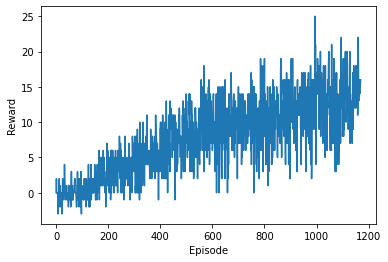

In [5]:
# Plot the scores per episode
plt.figure()
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

## Visualize a Smart Agent
> *Note*: Sometimes this cell requires a fresh kernel restart.

The code below will load the model parameters for a pre-trained agent and run the agent in the environment.

In [6]:
from dqn import env_step, create_default_agent

# Load model
smart_agent = create_default_agent(env)
smart_agent.dqn.load_state_dict(torch.load(model_output_path))

# Visualize 4 episodes
brain_name = env.brain_names[0]
smart_agent_scores = []
for _ in range(4):
    smart_agent_score = 0.0
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    while True:
        # By default, the agent uses an epsilon of 0.0, which is equivalent to using a greedy policy
        action = smart_agent.act(state)
        state, reward, done = env_step(env, brain_name, action)
        smart_agent_score += reward
        if done:
            break
    smart_agent_scores.append(smart_agent_score)

In [6]:
# Print out the scores collected by the smart agent in each episode
smart_agent_scores

[14.0, 15.0, 10.0, 17.0]

## Cleanup

In [7]:
# Close the environment
env.close()